In [1]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tifffile as tiff
import cv2
from tqdm import tqdm

In [2]:
division = 300
resize_img = 500
BS_train = 4
BS_val = 16
EPOCHS = 100
LR = 3e-4

In [3]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'submission.csv']

In [4]:
train_images_path = data_path / "train_images"

In [5]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## ResNet 50 UNet

In [6]:
number_of_classes = 2 # 2 classes
number_of_channels = 3

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        # x_in = torch.tensor(x.clone().detach())
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

## Dice coefficient loss

In [7]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Train all images

In [8]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [9]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [10]:
dataset = {
    'train': Dataset(train_df[:division], n_classes=2, dim=resize_img),
    'val': Dataset(train_df[division:], n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 300 imágenes de entrenamiento y 51 imágenes de validación


In [11]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

In [12]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'test_loss': [], 'test_dice': []}
    for epoch in range(epochs):
        bar = tqdm(dataloader['train'])
        train_loss, train_dice = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)
            loss.backward()
            optimizer.step()
            dice = dice_coeff(pred_mask, masks)
            train_loss.append(loss.item())
            train_dice.append(dice)
            bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['dice'].append(np.mean(train_dice))
        bar = tqdm(dataloader['test'])
        test_loss, test_dice = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                pred_mask = model(imgs)
                loss = criterion(pred_mask, masks)
                dice = dice_coeff(pred_mask, masks)
                test_loss.append(loss.item())
                test_dice.append(dice)
                bar.set_description(f"\t\ttest_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_dice'].append(np.mean(test_dice))
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
    return hist

In [13]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 1 GPUs!


		test_loss 0.27393 test_dice 2.62807: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Epoch 001/100 loss 0.38904 dice 1.71775 test_loss 0.27393 test_dice 2.62807


		test_loss 0.24662 test_dice 2.75670: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 002/100 loss 0.25927 dice 2.67039 test_loss 0.24662 test_dice 2.75670


		test_loss 0.21133 test_dice 3.28189: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 003/100 loss 0.20680 dice 3.31749 test_loss 0.21133 test_dice 3.28189


		test_loss 0.16104 test_dice 4.00522: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Epoch 004/100 loss 0.17531 dice 3.96881 test_loss 0.16104 test_dice 4.00522


		test_loss 0.19327 test_dice 5.16571: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 005/100 loss 0.14868 dice 4.54072 test_loss 0.19327 test_dice 5.16571


		test_loss 0.15099 test_dice 5.00860: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 006/100 loss 0.12849 dice 5.04864 test_loss 0.15099 test_dice 5.00860


		test_loss 0.15744 test_dice 5.40680: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 007/100 loss 0.11861 dice 5.46480 test_loss 0.15744 test_dice 5.40680


		test_loss 0.12064 test_dice 5.89456: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 008/100 loss 0.12160 dice 5.78953 test_loss 0.12064 test_dice 5.89456


		test_loss 0.12227 test_dice 6.30773: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 009/100 loss 0.09841 dice 6.22194 test_loss 0.12227 test_dice 6.30773


		test_loss 0.18662 test_dice 5.53280: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 010/100 loss 0.09558 dice 6.53788 test_loss 0.18662 test_dice 5.53280


		test_loss 0.31239 test_dice 5.53851: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 011/100 loss 0.08666 dice 6.85507 test_loss 0.31239 test_dice 5.53851


		test_loss 0.12050 test_dice 6.83233: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 012/100 loss 0.07705 dice 7.18113 test_loss 0.12050 test_dice 6.83233


		test_loss 0.09972 test_dice 7.51549: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 013/100 loss 0.06507 dice 7.50286 test_loss 0.09972 test_dice 7.51549


		test_loss 0.11436 test_dice 7.23564: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 014/100 loss 0.05776 dice 7.80898 test_loss 0.11436 test_dice 7.23564


		test_loss 0.10938 test_dice 7.54909: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 015/100 loss 0.05945 dice 8.05555 test_loss 0.10938 test_dice 7.54909


		test_loss 0.11564 test_dice 8.22895: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 016/100 loss 0.04805 dice 8.32658 test_loss 0.11564 test_dice 8.22895


		test_loss 0.10849 test_dice 8.29276: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 017/100 loss 0.04293 dice 8.60436 test_loss 0.10849 test_dice 8.29276


		test_loss 0.11747 test_dice 8.68570: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 018/100 loss 0.04327 dice 8.81202 test_loss 0.11747 test_dice 8.68570


		test_loss 0.66535 test_dice 7.00186: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 019/100 loss 0.04380 dice 9.00367 test_loss 0.66535 test_dice 7.00186


		test_loss 0.12606 test_dice 9.08035: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 020/100 loss 0.05392 dice 9.04877 test_loss 0.12606 test_dice 9.08035


		test_loss 0.14786 test_dice 8.23798: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 021/100 loss 0.04689 dice 9.30611 test_loss 0.14786 test_dice 8.23798


		test_loss 0.13887 test_dice 9.34777: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 022/100 loss 0.04884 dice 9.41421 test_loss 0.13887 test_dice 9.34777


		test_loss 0.11919 test_dice 9.03969: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 023/100 loss 0.04102 dice 9.68085 test_loss 0.11919 test_dice 9.03969


		test_loss 0.11703 test_dice 9.47850: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 024/100 loss 0.03330 dice 9.90224 test_loss 0.11703 test_dice 9.47850


		test_loss 0.11894 test_dice 9.67916: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 025/100 loss 0.02961 dice 10.12373 test_loss 0.11894 test_dice 9.67916


		test_loss 0.12543 test_dice 9.76562: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 026/100 loss 0.02722 dice 10.29748 test_loss 0.12543 test_dice 9.76562


		test_loss 0.13873 test_dice 9.91651: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 027/100 loss 0.02714 dice 10.42642 test_loss 0.13873 test_dice 9.91651


		test_loss 0.13778 test_dice 10.09775: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 028/100 loss 0.02393 dice 10.63203 test_loss 0.13778 test_dice 10.09775


		test_loss 0.13303 test_dice 10.43627: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 029/100 loss 0.02225 dice 10.78956 test_loss 0.13303 test_dice 10.43627


		test_loss 0.14232 test_dice 10.34948: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 030/100 loss 0.02137 dice 10.94008 test_loss 0.14232 test_dice 10.34948


		test_loss 0.13968 test_dice 10.60605: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Epoch 031/100 loss 0.01982 dice 11.10452 test_loss 0.13968 test_dice 10.60605


		test_loss 0.15006 test_dice 10.45317: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 032/100 loss 0.01863 dice 11.25031 test_loss 0.15006 test_dice 10.45317


		test_loss 0.14645 test_dice 10.74520: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 033/100 loss 0.01765 dice 11.38774 test_loss 0.14645 test_dice 10.74520


		test_loss 0.15210 test_dice 10.86989: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 034/100 loss 0.01683 dice 11.50844 test_loss 0.15210 test_dice 10.86989


		test_loss 0.15308 test_dice 10.91331: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 035/100 loss 0.01614 dice 11.64896 test_loss 0.15308 test_dice 10.91331


		test_loss 0.16410 test_dice 11.27299: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 036/100 loss 0.01533 dice 11.79654 test_loss 0.16410 test_dice 11.27299


		test_loss 0.16048 test_dice 11.16696: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 037/100 loss 0.01597 dice 11.95791 test_loss 0.16048 test_dice 11.16696


		test_loss 0.16034 test_dice 11.33903: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 038/100 loss 0.01501 dice 12.12278 test_loss 0.16034 test_dice 11.33903


		test_loss 0.16354 test_dice 11.52338: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 039/100 loss 0.01471 dice 12.27354 test_loss 0.16354 test_dice 11.52338


		test_loss 0.16681 test_dice 11.55898: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 040/100 loss 0.01430 dice 12.42177 test_loss 0.16681 test_dice 11.55898


		test_loss 0.16698 test_dice 11.90443: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 041/100 loss 0.01427 dice 12.55032 test_loss 0.16698 test_dice 11.90443


		test_loss 0.17373 test_dice 12.08132: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 042/100 loss 0.01441 dice 12.67574 test_loss 0.17373 test_dice 12.08132


		test_loss 0.18676 test_dice 12.39673: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 043/100 loss 0.01613 dice 12.76131 test_loss 0.18676 test_dice 12.39673


		test_loss 0.17290 test_dice 12.08599: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 044/100 loss 0.01514 dice 12.84280 test_loss 0.17290 test_dice 12.08599


		test_loss 0.17666 test_dice 12.21718: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 045/100 loss 0.01313 dice 12.99996 test_loss 0.17666 test_dice 12.21718


		test_loss 0.17543 test_dice 12.34760: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 046/100 loss 0.01223 dice 13.10776 test_loss 0.17543 test_dice 12.34760


		test_loss 0.18066 test_dice 12.43588: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 047/100 loss 0.01190 dice 13.23371 test_loss 0.18066 test_dice 12.43588


		test_loss 0.19176 test_dice 12.56941: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 048/100 loss 0.01112 dice 13.34971 test_loss 0.19176 test_dice 12.56941


		test_loss 0.18440 test_dice 12.53721: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 049/100 loss 0.01083 dice 13.45183 test_loss 0.18440 test_dice 12.53721


		test_loss 0.19010 test_dice 12.84417: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 050/100 loss 0.01063 dice 13.54835 test_loss 0.19010 test_dice 12.84417


		test_loss 0.19323 test_dice 12.90147: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 051/100 loss 0.01094 dice 13.63339 test_loss 0.19323 test_dice 12.90147


		test_loss 0.19540 test_dice 13.08690: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 052/100 loss 0.01035 dice 13.76817 test_loss 0.19540 test_dice 13.08690


		test_loss 0.19594 test_dice 13.13395: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 053/100 loss 0.01023 dice 13.81853 test_loss 0.19594 test_dice 13.13395


		test_loss 0.19391 test_dice 13.14831: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 054/100 loss 0.01066 dice 13.95853 test_loss 0.19391 test_dice 13.14831


		test_loss 0.20108 test_dice 13.13202: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 055/100 loss 0.01070 dice 14.04707 test_loss 0.20108 test_dice 13.13202


		test_loss 0.19898 test_dice 13.37402: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 056/100 loss 0.00942 dice 14.13429 test_loss 0.19898 test_dice 13.37402


		test_loss 0.20309 test_dice 13.56218: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 057/100 loss 0.00962 dice 14.22573 test_loss 0.20309 test_dice 13.56218


		test_loss 0.20467 test_dice 13.48057: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 058/100 loss 0.00940 dice 14.31953 test_loss 0.20467 test_dice 13.48057


		test_loss 0.20626 test_dice 13.32800: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 059/100 loss 0.00932 dice 14.40215 test_loss 0.20626 test_dice 13.32800


		test_loss 0.21319 test_dice 13.75627: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 060/100 loss 0.00899 dice 14.46952 test_loss 0.21319 test_dice 13.75627


		test_loss 0.22426 test_dice 13.71586: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch 061/100 loss 0.00860 dice 14.57481 test_loss 0.22426 test_dice 13.71586


		test_loss 0.21637 test_dice 13.61916: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 062/100 loss 0.00875 dice 14.66311 test_loss 0.21637 test_dice 13.61916


		test_loss 0.22500 test_dice 13.95467: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 063/100 loss 0.00878 dice 14.76471 test_loss 0.22500 test_dice 13.95467


		test_loss 0.21922 test_dice 14.23637: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 064/100 loss 0.00852 dice 14.86133 test_loss 0.21922 test_dice 14.23637


		test_loss 0.22236 test_dice 13.96778: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 065/100 loss 0.00919 dice 14.93215 test_loss 0.22236 test_dice 13.96778


		test_loss 0.22938 test_dice 14.13966: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 066/100 loss 0.00920 dice 15.00539 test_loss 0.22938 test_dice 14.13966


		test_loss 0.21769 test_dice 13.97317: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 067/100 loss 0.00873 dice 15.11385 test_loss 0.21769 test_dice 13.97317


		test_loss 0.21560 test_dice 14.01885: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 068/100 loss 0.00885 dice 15.20571 test_loss 0.21560 test_dice 14.01885


		test_loss 0.21766 test_dice 14.34966: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 069/100 loss 0.00844 dice 15.31286 test_loss 0.21766 test_dice 14.34966


		test_loss 0.23209 test_dice 14.51696: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 070/100 loss 0.00859 dice 15.36991 test_loss 0.23209 test_dice 14.51696


		test_loss 0.22358 test_dice 14.71672: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 071/100 loss 0.00822 dice 15.43817 test_loss 0.22358 test_dice 14.71672


		test_loss 0.23525 test_dice 14.51478: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Epoch 072/100 loss 0.00776 dice 15.56687 test_loss 0.23525 test_dice 14.51478


		test_loss 0.24113 test_dice 14.59339: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 073/100 loss 0.00775 dice 15.64015 test_loss 0.24113 test_dice 14.59339


		test_loss 1.29651 test_dice 1.72105: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 074/100 loss 0.06552 dice 14.34665 test_loss 1.29651 test_dice 1.72105


		test_loss 0.20267 test_dice 10.91042: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 075/100 loss 0.16919 dice 9.40057 test_loss 0.20267 test_dice 10.91042


		test_loss 0.13201 test_dice 10.86064: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 076/100 loss 0.10925 dice 9.64599 test_loss 0.13201 test_dice 10.86064


		test_loss 0.12887 test_dice 10.29811: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 077/100 loss 0.08279 dice 10.31419 test_loss 0.12887 test_dice 10.29811


		test_loss 0.19607 test_dice 10.01567: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 078/100 loss 0.06106 dice 11.37351 test_loss 0.19607 test_dice 10.01567


		test_loss 0.12348 test_dice 11.88668: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 079/100 loss 0.03495 dice 12.31521 test_loss 0.12348 test_dice 11.88668


		test_loss 0.13712 test_dice 12.52697: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 080/100 loss 0.02146 dice 13.08911 test_loss 0.13712 test_dice 12.52697


		test_loss 0.15018 test_dice 12.93167: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 081/100 loss 0.01663 dice 13.62625 test_loss 0.15018 test_dice 12.93167


		test_loss 0.14634 test_dice 13.42724: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Epoch 082/100 loss 0.01523 dice 14.05570 test_loss 0.14634 test_dice 13.42724


		test_loss 0.20507 test_dice 12.96887: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 083/100 loss 0.01291 dice 14.40297 test_loss 0.20507 test_dice 12.96887


		test_loss 0.15272 test_dice 13.63942: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 084/100 loss 0.01789 dice 14.55115 test_loss 0.15272 test_dice 13.63942


		test_loss 0.16332 test_dice 14.00558: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 085/100 loss 0.01555 dice 14.70886 test_loss 0.16332 test_dice 14.00558


		test_loss 0.16539 test_dice 14.28941: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Epoch 086/100 loss 0.01152 dice 15.07849 test_loss 0.16539 test_dice 14.28941


		test_loss 0.17332 test_dice 14.52316: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 087/100 loss 0.01006 dice 15.35204 test_loss 0.17332 test_dice 14.52316


		test_loss 0.17198 test_dice 14.74543: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 088/100 loss 0.00942 dice 15.58333 test_loss 0.17198 test_dice 14.74543


		test_loss 0.18467 test_dice 14.94805: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 089/100 loss 0.00869 dice 15.79262 test_loss 0.18467 test_dice 14.94805


		test_loss 0.18379 test_dice 15.13448: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 090/100 loss 0.00810 dice 16.02753 test_loss 0.18379 test_dice 15.13448


		test_loss 0.18451 test_dice 15.31862: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 091/100 loss 0.00823 dice 16.17761 test_loss 0.18451 test_dice 15.31862


		test_loss 0.19162 test_dice 15.54675: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Epoch 092/100 loss 0.00778 dice 16.40614 test_loss 0.19162 test_dice 15.54675


		test_loss 0.19881 test_dice 15.72244: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 093/100 loss 0.00806 dice 16.54802 test_loss 0.19881 test_dice 15.72244


		test_loss 0.19418 test_dice 15.88465: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 094/100 loss 0.00813 dice 16.75209 test_loss 0.19418 test_dice 15.88465


		test_loss 0.19676 test_dice 15.99199: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 095/100 loss 0.00770 dice 16.95271 test_loss 0.19676 test_dice 15.99199


		test_loss 0.19157 test_dice 16.13642: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 096/100 loss 0.00727 dice 17.14854 test_loss 0.19157 test_dice 16.13642


		test_loss 0.19058 test_dice 16.37364: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Epoch 097/100 loss 0.00702 dice 17.33694 test_loss 0.19058 test_dice 16.37364


		test_loss 0.19958 test_dice 16.33453: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Epoch 098/100 loss 0.00709 dice 17.44685 test_loss 0.19958 test_dice 16.33453


		test_loss 0.18658 test_dice 14.53196: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Epoch 099/100 loss 0.02897 dice 16.55810 test_loss 0.18658 test_dice 14.53196


		test_loss 0.15554 test_dice 14.12009: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

Epoch 100/100 loss 0.04108 dice 15.43042 test_loss 0.15554 test_dice 14.12009


In [14]:
model_path = path / 'models' / '07_unet_resnet50_DataParallel.zip'
torch.jit.save(torch.jit.script(model.cpu()), model_path)
model_path = path / 'models' / '07_unet_resnet50_DataParallel.pth'
path = "data/modelo.pth"
torch.save(model, model_path)

In [15]:
hist_df = pd.DataFrame(hist)
print(len(hist_df))
hist_df.head()

100


,loss,dice,test_loss,test_dice
0,0.389044,1.717750,0.273932,2.628075
1,0.259265,2.670395,0.246618,2.756703
2,0.206798,3.317486,0.211326,3.281888
3,0.175314,3.968806,0.161043,4.005224
4,0.148677,4.540715,0.193272,5.165706


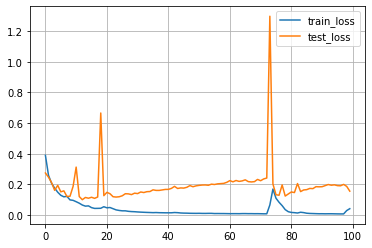

In [16]:
# plot the training and testing loss
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['test_loss'], label='test_loss')
plt.legend()
plt.grid()
plt.show()

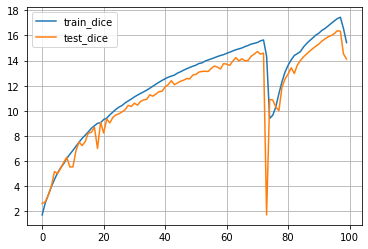

In [17]:
# plot the training and testing dice
plt.plot(hist['dice'], label='train_dice')
plt.plot(hist['test_dice'], label='test_dice')
plt.legend()
plt.grid()
plt.show()

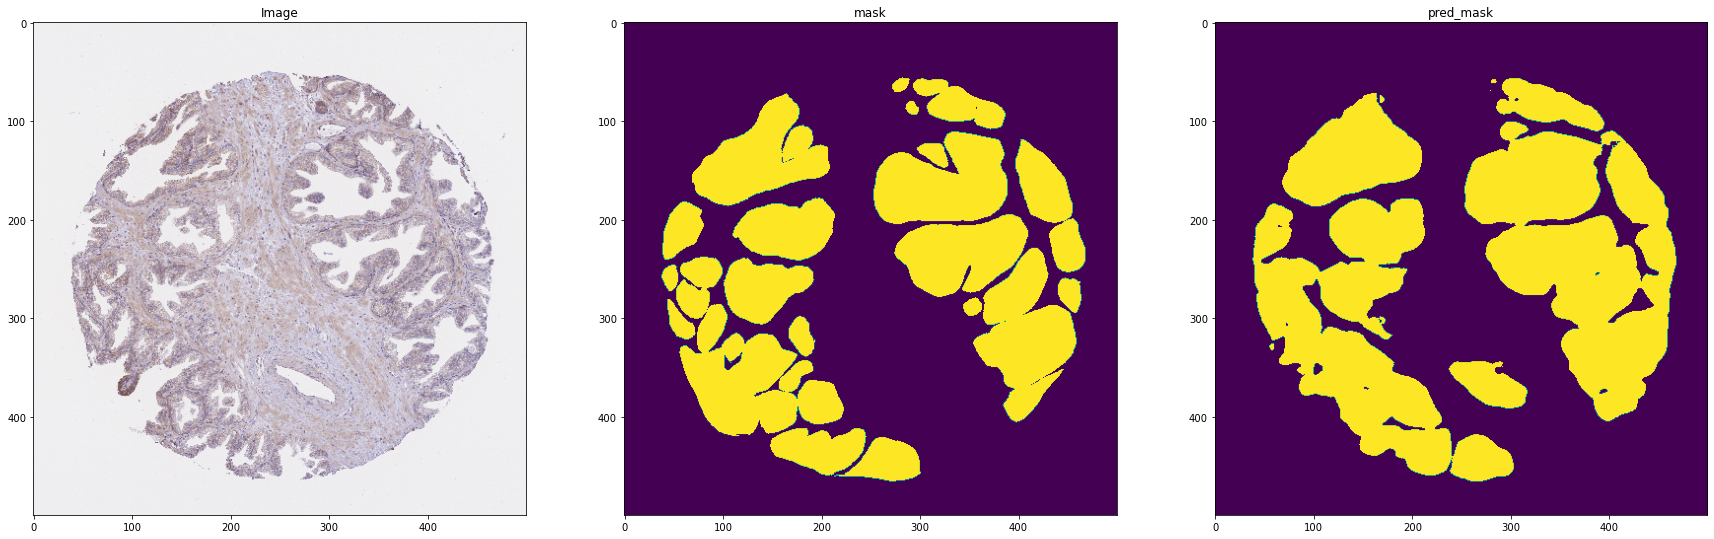

output.shape = torch.Size([2, 500, 500]), pred_mask.shape = torch.Size([500, 500])


In [18]:
sample_val_img, sample_val_mask = next(iter(dataloader['test']))
one_sample_img = sample_val_img[0]
one_sample_mask = sample_val_mask[0]
model.eval()
with torch.no_grad():
    output = model(sample_val_img)[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
ax1.set_title('Image')
ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")